In [ ]:
!pip install albumentations

In [11]:
import albumentations as A
import cv2
import numpy as np
import os
from glob import glob
import random

# Define augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.2)
])

# Load images from folder
image_paths = glob("/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/*.png") # Change path accordingly
save_folder = "/content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images"
os.makedirs(save_folder, exist_ok=True)

# Augment and save images
for img_path in image_paths:
    img = cv2.imread(img_path)

    if img is None:
        print(f"Warning: Could not read image {img_path}")
        continue

    for i in range(10):
        augmented = augmentations(image=img)['image']
        filename = os.path.join(save_folder, f"{os.path.basename(img_path).split('.')[0]}_aug_{i}.png")

        print(f"Saving: {filename}")  # Debugging: Check if filenames are generated
        cv2.imwrite(filename, augmented)

print("Augmentation completed!")


Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage_aug_0.png
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage_aug_1.png
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage_aug_2.png
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage_aug_3.png
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage_aug_4.png
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage_aug_5.png
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage_aug_6.png
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage_aug_7.png
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage_aug_8.png
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage_aug_9.png
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImag

In [17]:
import json
import os
import cv2
import albumentations as A

# Define the path to your COCO JSON file
json_file_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/labels_my-project-name_2025-03-07-10-07-36.json"

# Load COCO JSON file
with open(json_file_path, "r") as f:
    coco_data = json.load(f)

# Define augmentation (must use bbox-compatible transformations)
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7)
], bbox_params=A.BboxParams(format='coco', label_fields=['category_id']))

# Create output folder for augmented images
os.makedirs("augmented_images", exist_ok=True)

new_images = []
new_annotations = []
new_image_id = max(img["id"] for img in coco_data["images"]) + 1
new_annotation_id = max(ann["id"] for ann in coco_data["annotations"]) + 1

# Process each image
for img_info in coco_data["images"]:
    img_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites", img_info["file_name"])  # Change to your actual image folder path
    img = cv2.imread(img_path)

    if img is None:
        print(f"Skipping {img_info['file_name']} (not found)")
        continue

    # Get annotations for this image
    ann_ids = [ann for ann in coco_data["annotations"] if ann["image_id"] == img_info["id"]]
    bboxes = [ann["bbox"] for ann in ann_ids]
    category_ids = [ann["category_id"] for ann in ann_ids]

    for i in range(10):  # Generate 10 augmented images per original
        # Apply augmentation
        augmented = augmentations(image=img, bboxes=bboxes, category_id=category_ids)

        # Save augmented image
        new_filename = img_info["file_name"].replace(".jpg", f"_aug_{i}.jpg").replace(".png", f"_aug_{i}.png")
        cv2.imwrite(os.path.join("augmented_images", new_filename), augmented["image"])

        # Add new image entry to COCO JSON
        new_img_info = img_info.copy()
        new_img_info["file_name"] = new_filename
        new_img_info["id"] = new_image_id
        new_images.append(new_img_info)

        # Add new annotations
        for j, ann in enumerate(ann_ids):
            new_ann = ann.copy()
            new_ann["id"] = new_annotation_id
            new_ann["bbox"] = augmented["bboxes"][j]
            new_ann["image_id"] = new_image_id
            new_annotations.append(new_ann)
            new_annotation_id += 1  # Increment annotation ID

        new_image_id += 1  # Increment image ID

# Update COCO JSON
coco_data["images"].extend(new_images)
coco_data["annotations"].extend(new_annotations)

# Save new COCO JSON
with open("/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json", "w") as f:
    json.dump(coco_data, f)

print("COCO annotations updated with augmented images!")


COCO annotations updated with augmented images!


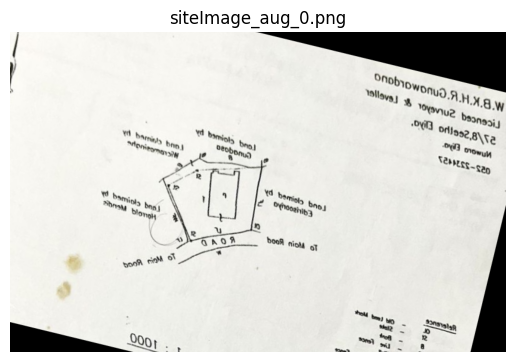

In [ ]:
import cv2
import matplotlib.pyplot as plt
import json
import os

# Load augmented COCO JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Find an image entry with an augmented file name (e.g., one containing '_aug_')
aug_image_info = next((img for img in coco_data["images"] if "_aug_" in img["file_name"]), None)
if aug_image_info:
    img_path = f"/content/augmented_images/{aug_image_info['file_name']}"
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(aug_image_info['file_name'])
        plt.axis("off")
        plt.show()
    else:
        print(f"Augmented image not found at: {img_path}")
else:
    print("No augmented image entry found in JSON.")


In [ ]:
import os
print(os.listdir("/content/augmented_images"))


['siteImage1_aug_8.png', 'siteImage1_aug_0.png', 'siteImage2_aug_1.jpg', 'siteImage2_aug_9.jpg', 'siteImage_aug_8.jpg', 'siteImage1_aug_7.jpg', 'siteImage1_aug_5.jpg', 'siteImage2_aug_5.png', 'siteImage2_aug_7.jpg', 'siteImage_aug_9.png', 'siteImage_aug_5.jpg', 'siteImage_aug_8.png', 'siteImage2_aug_8.jpg', 'siteImage_aug_2.png', 'siteImage1_aug_4.jpg', 'siteImage1_aug_3.png', 'siteImage1_aug_7.png', 'siteImage_aug_5.png', 'siteImage2_aug_6.jpg', 'siteImage2_aug_6.png', 'siteImage_aug_4.jpg', 'siteImage2_aug_4.jpg', 'siteImage2_aug_4.png', 'siteImage_aug_4.png', 'siteImage_aug_9.jpg', 'siteImage2_aug_0.png', 'siteImage1_aug_2.png', 'siteImage1_aug_1.jpg', 'siteImage_aug_2.jpg', 'siteImage2_aug_1.png', 'siteImage_aug_6.png', 'siteImage2_aug_2.jpg', 'siteImage_aug_1.jpg', 'siteImage_aug_7.png', 'siteImage2_aug_5.jpg', 'siteImage1_aug_5.png', 'siteImage_aug_0.png', 'siteImage1_aug_2.jpg', 'siteImage1_aug_4.png', 'siteImage2_aug_7.png', 'siteImage2_aug_2.png', 'siteImage1_aug_1.png', 'site

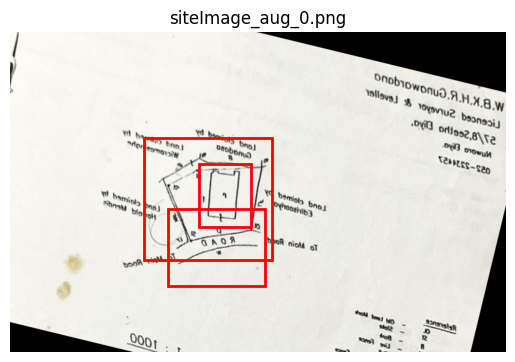

In [ ]:
import cv2
import matplotlib.pyplot as plt
import json
import os

# Load augmented COCO JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Pick one augmented image (look for '_aug_' in the filename)
aug_image_info = next((img for img in coco_data["images"] if "_aug_" in img["file_name"]), None)
if aug_image_info is not None:
    img_path = f"/content/augmented_images/{aug_image_info['file_name']}"
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == aug_image_info["id"]]

        plt.imshow(img)
        ax = plt.gca()
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))
        plt.title(aug_image_info['file_name'])
        plt.axis("off")
        plt.show()
    else:
        print(f"Augmented image not found at: {img_path}")
else:
    print("No augmented image entry found in JSON.")


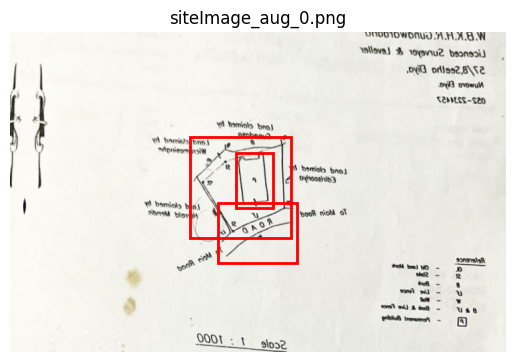

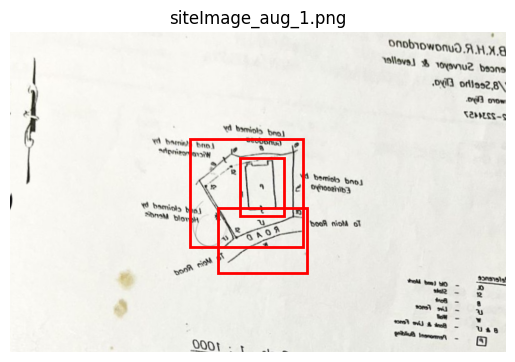

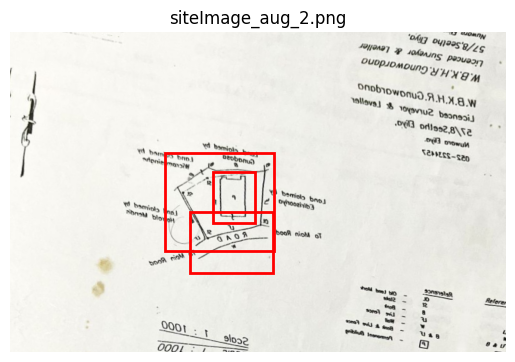

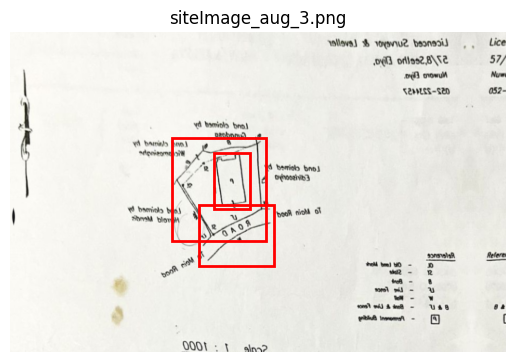

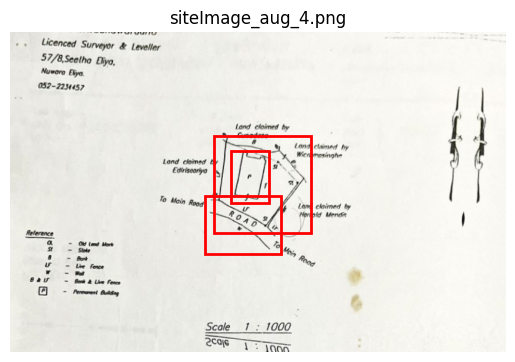

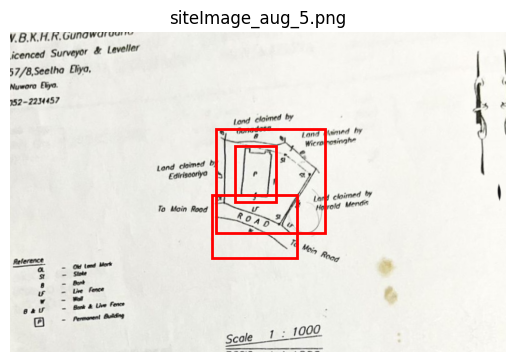

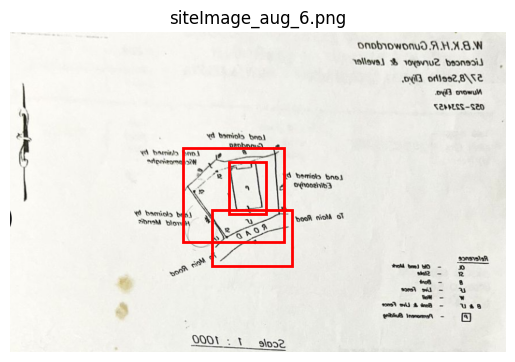

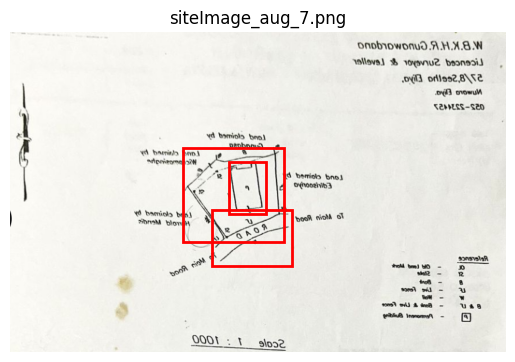

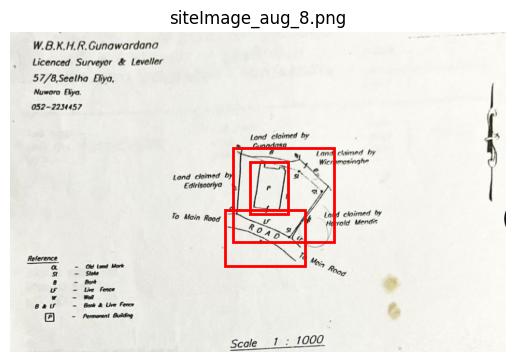

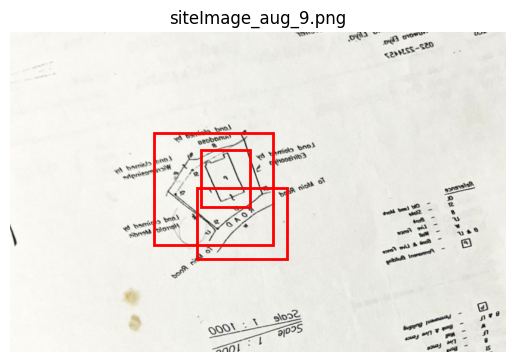

KeyboardInterrupt: 

In [16]:
import cv2
import matplotlib.pyplot as plt
import json
import os

# Load augmented COCO JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Dataset-Sites/augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Loop through the augmented images in the JSON and display them
for aug_image_info in coco_data["images"]:
    if "_aug_" in aug_image_info["file_name"]:  # Only show augmented images
        img_path = f"/content/augmented_images/{aug_image_info['file_name']}"

        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

            annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == aug_image_info["id"]]

            # Plot image with bounding boxes
            plt.imshow(img)
            ax = plt.gca()
            for ann in annotations:
                x, y, w, h = ann["bbox"]
                ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))

            plt.title(aug_image_info['file_name'])
            plt.axis("off")
            plt.show()
        else:
            print(f"Augmented image not found at: {img_path}")

In [ ]:
import json
import os

# Path to your images and augmented labels
images_dir = '/content/augmented_images'  # Adjust as needed
output_dir = '/content/yolo_annotations'  # Folder to store YOLO annotations
os.makedirs(output_dir, exist_ok=True)

# Load COCO JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Example mapping of COCO categories to YOLO class ids
class_mapping = {
    "class_name_1": 0,  # Replace with actual class names and corresponding IDs
    "class_name_2": 1,
    # Add more classes as needed
}

# Convert COCO annotations to YOLO format
for image_info in coco_data["images"]:
    img_name = image_info["file_name"]
    img_width = image_info["width"]
    img_height = image_info["height"]

    # Prepare path for the YOLO annotation file
    yolo_annotation_file = os.path.join(output_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    # Get annotations for the current image
    annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == image_info["id"]]

    # Open the YOLO annotation file for writing
    with open(yolo_annotation_file, 'w') as f:
        for ann in annotations:
            # Extract the class and bounding box
            class_name = coco_data["categories"][ann["category_id"] - 1]["name"]
            class_id = class_mapping.get(class_name, -1)  # Map class name to YOLO class ID

            # COCO bbox format [x, y, width, height]
            x, y, width, height = ann["bbox"]

            # Normalize bbox coordinates to YOLO format
            x_center = (x + width / 2) / img_width
            y_center = (y + height / 2) / img_height
            normalized_width = width / img_width
            normalized_height = height / img_height

            # Write the YOLO annotation in the text file
            f.write(f"{class_id} {x_center} {y_center} {normalized_width} {normalized_height}\n")

    print(f"Processed {img_name}")

print("Conversion completed!")


Processed siteImage.png
Processed siteImage1.png
Processed siteImage2.png
Processed siteImage_aug_0.png
Processed siteImage_aug_1.png
Processed siteImage_aug_2.png
Processed siteImage_aug_3.png
Processed siteImage_aug_4.png
Processed siteImage_aug_5.png
Processed siteImage_aug_6.png
Processed siteImage_aug_7.png
Processed siteImage_aug_8.png
Processed siteImage_aug_9.png
Processed siteImage1_aug_0.png
Processed siteImage1_aug_1.png
Processed siteImage1_aug_2.png
Processed siteImage1_aug_3.png
Processed siteImage1_aug_4.png
Processed siteImage1_aug_5.png
Processed siteImage1_aug_6.png
Processed siteImage1_aug_7.png
Processed siteImage1_aug_8.png
Processed siteImage1_aug_9.png
Processed siteImage2_aug_0.png
Processed siteImage2_aug_1.png
Processed siteImage2_aug_2.png
Processed siteImage2_aug_3.png
Processed siteImage2_aug_4.png
Processed siteImage2_aug_5.png
Processed siteImage2_aug_6.png
Processed siteImage2_aug_7.png
Processed siteImage2_aug_8.png
Processed siteImage2_aug_9.png
Conver

In [ ]:
!pip install opencv-python


In [20]:
import os
import json
import cv2

# Function to convert a COCO bbox to YOLO format
def convert_to_yolo_format(coco_bbox, img_width, img_height):
    x, y, w, h = coco_bbox
    # Calculate center coordinates and normalize them
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    norm_w = w / img_width
    norm_h = h / img_height
    return [x_center, y_center, norm_w, norm_h]

# Define paths (adjust these paths to your environment)
json_file_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json'
images_dir = '/content/augmented_images'
output_labels_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/yolo_labels/'

# Create the output directory if it doesn't exist
os.makedirs(output_labels_dir, exist_ok=True)

# Load the updated COCO JSON file
with open(json_file_path, 'r') as f:
    coco_data = json.load(f)

# Build a mapping from COCO category IDs to YOLO category IDs
# Example: if your COCO category IDs start at 1, YOLO usually starts at 0
class_mapping = {}
for cat in coco_data["categories"]:
    # Adjust mapping as needed, here subtracting 1 from COCO IDs to fit YOLO format
    class_mapping[cat["id"]] = cat["id"] - 1

# Process each image in the JSON file
for image_info in coco_data["images"]:
    image_filename = image_info["file_name"]
    # Convert .png to .jpg if necessary
    if image_filename.endswith(".png"):
        image_filename = image_filename.replace(".png", ".jpg")

    image_path = os.path.join(images_dir, image_filename)

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Warning: Image not found at {image_path}. Skipping.")
        continue

    # Load the image and get its dimensions
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Image {image_path} could not be loaded. Skipping.")
        continue
    img_h, img_w, _ = img.shape

    # Gather annotations for this image
    annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == image_info["id"]]

    yolo_lines = []
    for ann in annotations:
        # Get the COCO bounding box
        coco_bbox = ann["bbox"]
        # Convert to YOLO format (normalized)
        yolo_bbox = convert_to_yolo_format(coco_bbox, img_w, img_h)
        # Map the COCO class id to YOLO class id
        coco_class_id = ann["category_id"]
        yolo_class_id = class_mapping.get(coco_class_id, coco_class_id)
        # Create the YOLO annotation line
        line = "{} {:.6f} {:.6f} {:.6f} {:.6f}".format(yolo_class_id, *yolo_bbox)
        yolo_lines.append(line)

    # Save the YOLO annotations to a text file (same base name as the image)
    label_filename = os.path.splitext(image_filename)[0] + '.txt'
    output_path = os.path.join(output_labels_dir, label_filename)
    with open(output_path, 'w') as f:
        for line in yolo_lines:
            f.write(line + "\n")

    print(f"Processed {image_filename}")

print("COCO to YOLO conversion completed!")


Processed siteImage_aug_0.jpg
Processed siteImage_aug_1.jpg
Processed siteImage_aug_2.jpg
Processed siteImage_aug_3.jpg
Processed siteImage_aug_4.jpg
Processed siteImage_aug_5.jpg
Processed siteImage_aug_6.jpg
Processed siteImage_aug_7.jpg
Processed siteImage_aug_8.jpg
Processed siteImage_aug_9.jpg
Processed siteImage1_aug_0.jpg
Processed siteImage1_aug_1.jpg
Processed siteImage1_aug_2.jpg
Processed siteImage1_aug_3.jpg
Processed siteImage1_aug_4.jpg
Processed siteImage1_aug_5.jpg
Processed siteImage1_aug_6.jpg
Processed siteImage1_aug_7.jpg
Processed siteImage1_aug_8.jpg
Processed siteImage1_aug_9.jpg
Processed siteImage2_aug_0.jpg
Processed siteImage2_aug_1.jpg
Processed siteImage2_aug_2.jpg
Processed siteImage2_aug_3.jpg
Processed siteImage2_aug_4.jpg
Processed siteImage2_aug_5.jpg
Processed siteImage2_aug_6.jpg
Processed siteImage2_aug_7.jpg
Processed siteImage2_aug_8.jpg
Processed siteImage2_aug_9.jpg
COCO to YOLO conversion completed!


Image Dimensions: 832x537
Class 1: X=0.401231, Y=0.457954, W=0.234861, H=0.342188
Bounding Box (pixels): (236, 154) -> (431, 337)
Class 0: X=0.417133, Y=0.59337, W=0.178026, H=0.217063
Bounding Box (pixels): (272, 260) -> (421, 376)
Class 2: X=0.431577, Y=0.447686, W=0.095189, H=0.175497
Bounding Box (pixels): (319, 193) -> (398, 287)


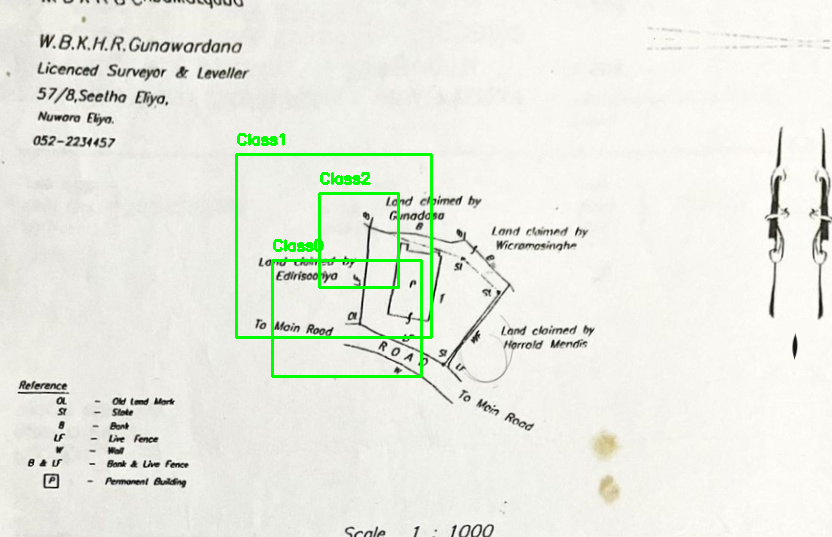

In [21]:
import cv2
import os
from google.colab.patches import cv2_imshow  # For Colab display

# Paths
image_dir = "/content/augmented_images"
label_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/yolo_labels"

# Class names (Ensure this matches your dataset's categories)
class_names = ["Class0", "Class1", "Class2"]  # Update with actual names

# Pick an image (Make sure this file exists!)
image_name = "siteImage_aug_0.jpg"
image_path = os.path.join(image_dir, image_name)
label_path = os.path.join(label_dir, image_name.replace(".jpg", ".txt"))

# Load the image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# Get image dimensions
img_h, img_w, _ = image.shape
print(f"Image Dimensions: {img_w}x{img_h}")

# Read YOLO annotations
if not os.path.exists(label_path):
    raise FileNotFoundError(f"Label file not found: {label_path}")

with open(label_path, "r") as f:
    lines = f.readlines()

if not lines:
    raise ValueError(f"No annotations found in {label_path}")

for line in lines:
    parts = line.strip().split()
    if len(parts) != 5:
        print(f"Skipping malformed annotation line: {line}")
        continue

    # Extract class ID and bbox coordinates
    class_id = int(parts[0])
    x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

    # Print extracted values to check correctness
    print(f"Class {class_id}: X={x_center}, Y={y_center}, W={bbox_width}, H={bbox_height}")

    # Convert to pixel coordinates
    x1 = int((x_center - bbox_width / 2) * img_w)
    y1 = int((y_center - bbox_height / 2) * img_h)
    x2 = int((x_center + bbox_width / 2) * img_w)
    y2 = int((y_center + bbox_height / 2) * img_h)

    # Print pixel coordinates before drawing
    print(f"Bounding Box (pixels): ({x1}, {y1}) -> ({x2}, {y2})")

    # Ensure coordinates are within bounds
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(img_w, x2), min(img_h, y2)

    # Draw bounding box
    color = (0, 255, 0)  # Green
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

    # Draw label text
    label = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the image in Colab
cv2_imshow(image)


Class: 1, X: 0.399044, Y: 0.52208, W: 0.257861, H: 0.381248
Bounding Box (pixels): (224, 177) -> (439, 382)
Class: 0, X: 0.416385, Y: 0.673732, W: 0.195422, H: 0.241247
Bounding Box (pixels): (265, 297) -> (427, 426)
Class: 2, X: 0.432349, Y: 0.510012, W: 0.104544, H: 0.196044
Bounding Box (pixels): (316, 221) -> (403, 326)


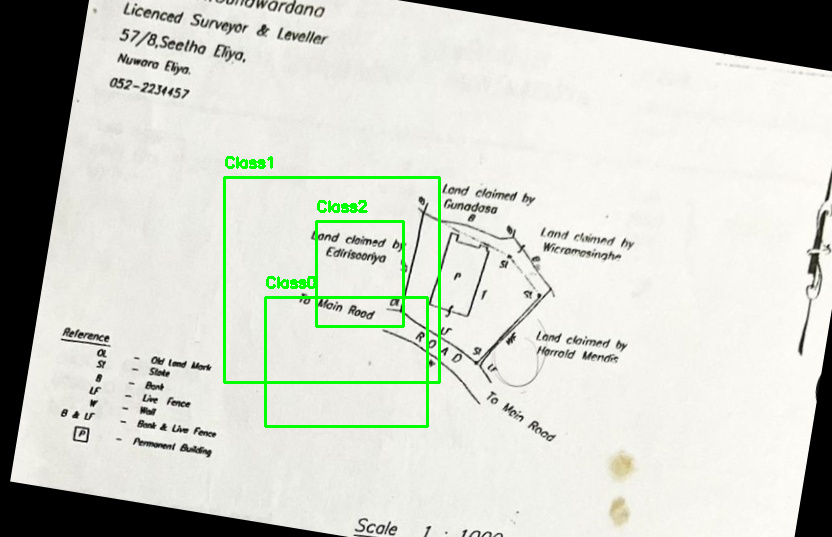

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Paths
image_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images"
label_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/yolo_labels"

# Define class names (Ensure they match the dataset!)
class_names = ["Class0", "Class1", "Class2"]  # Update this!

# Pick an image to visualize (Ensure it exists)
image_name = "siteImage_aug_0.jpg"
image_path = os.path.join(image_dir, image_name)
label_path = os.path.join(label_dir, image_name.replace(".jpg", ".txt"))

# Load the image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# Get image dimensions
img_h, img_w, _ = image.shape

# Read YOLO annotations
if not os.path.exists(label_path):
    raise FileNotFoundError(f"Label file not found: {label_path}")

with open(label_path, "r") as f:
    lines = f.readlines()

# Check if annotations exist
if not lines:
    raise ValueError(f"No annotations found in {label_path}")

for line in lines:
    parts = line.strip().split()
    if len(parts) != 5:
        print(f"Skipping malformed annotation line: {line}")
        continue

    # Extract class ID and bbox coordinates
    class_id = int(parts[0])
    x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

    # Debugging: Print extracted values to check correctness
    print(f"Class: {class_id}, X: {x_center}, Y: {y_center}, W: {bbox_width}, H: {bbox_height}")

    # Convert normalized values to pixel values
    x1 = int((x_center - bbox_width / 2) * img_w)
    y1 = int((y_center - bbox_height / 2) * img_h)
    x2 = int((x_center + bbox_width / 2) * img_w)
    y2 = int((y_center + bbox_height / 2) * img_h)

    # Debugging: Print final pixel coordinates
    print(f"Bounding Box (pixels): ({x1}, {y1}) -> ({x2}, {y2})")

    # Ensure coordinates are within image bounds
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(img_w, x2), min(img_h, y2)

    # Draw bounding box
    color = (0, 255, 0)  # Green
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

    # Draw label text
    label = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the image in Colab
cv2_imshow(image)


In [ ]:
import os

# Paths
label_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/yolo_labels"

# Expected label file
image_name = "siteImage_aug_0.jpg"
label_file = image_name.replace(".jpg", ".txt")
label_path = os.path.join(label_dir, label_file)

if os.path.exists(label_path):
    with open(label_path, "r") as f:
        print(f"Contents of {label_file}:\n")
        print(f.read())  # Print the label file contents
else:
    print(f"Label file {label_file} not found!")


Contents of siteImage_aug_0.txt:

1 0.399044 0.522080 0.257861 0.381248
0 0.416385 0.673732 0.195422 0.241247
2 0.432349 0.510012 0.104544 0.196044



In [ ]:
import cv2
import os

image_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage_aug_0.jpg"

# Load image
image = cv2.imread(image_path)
if image is None:
    print("Error: Image not found or unable to load.")
else:
    h, w, _ = image.shape
    print(f"Image dimensions: Width = {w}, Height = {h}")


Image dimensions: Width = 832, Height = 537


Loaded image siteImage_aug_0.jpg with dimensions: 832x537


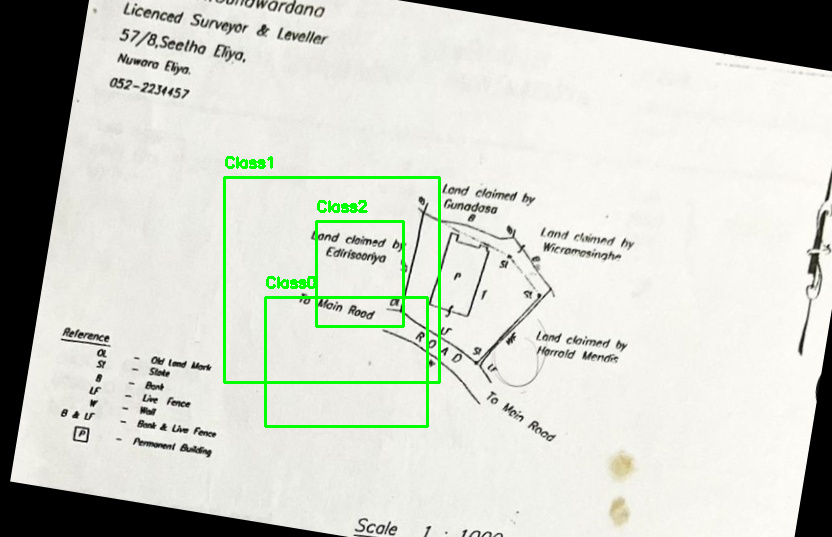

In [ ]:
import cv2
import os

# Paths
image_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images"
label_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/yolo_labels"
class_names = ["Class0", "Class1", "Class2"]  # Ensure correct class names

# Load image
image_name = "siteImage_aug_0.jpg"
image_path = os.path.join(image_dir, image_name)
label_path = os.path.join(label_dir, image_name.replace(".jpg", ".txt"))

image = cv2.imread(image_path)
if image is None:
    print(f"Error: Could not load image {image_path}")
    exit()

h, w, _ = image.shape  # Get correct image dimensions
print(f"Loaded image {image_name} with dimensions: {w}x{h}")

# Read YOLO annotations
if not os.path.exists(label_path):
    print(f"Error: Label file {label_path} not found!")
    exit()

with open(label_path, "r") as f:
    lines = f.readlines()

# Overlay bounding boxes
for line in lines:
    parts = line.strip().split()
    class_id = int(parts[0])
    x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

    # Convert YOLO normalized values back to pixel coordinates
    x1 = int((x_center - bbox_width / 2) * w)
    y1 = int((y_center - bbox_height / 2) * h)
    x2 = int((x_center + bbox_width / 2) * w)
    y2 = int((y_center + bbox_height / 2) * h)

    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, class_names[class_id], (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert for displaying in Colab
from google.colab.patches import cv2_imshow
cv2_imshow(image)  # Show the image
cv2.waitKey(0)
cv2.destroyAllWindows()


Image dimensions: Width = 832, Height = 537
Class 1: YOLO values - Center: (0.399044, 0.52208), Width: 0.257861, Height: 0.381248
Class 1: Pixel coordinates - Top-left: (224, 177), Bottom-right: (439, 382)
Class 0: YOLO values - Center: (0.416385, 0.673732), Width: 0.195422, Height: 0.241247
Class 0: Pixel coordinates - Top-left: (265, 297), Bottom-right: (427, 426)
Class 2: YOLO values - Center: (0.432349, 0.510012), Width: 0.104544, Height: 0.196044
Class 2: Pixel coordinates - Top-left: (316, 221), Bottom-right: (403, 326)


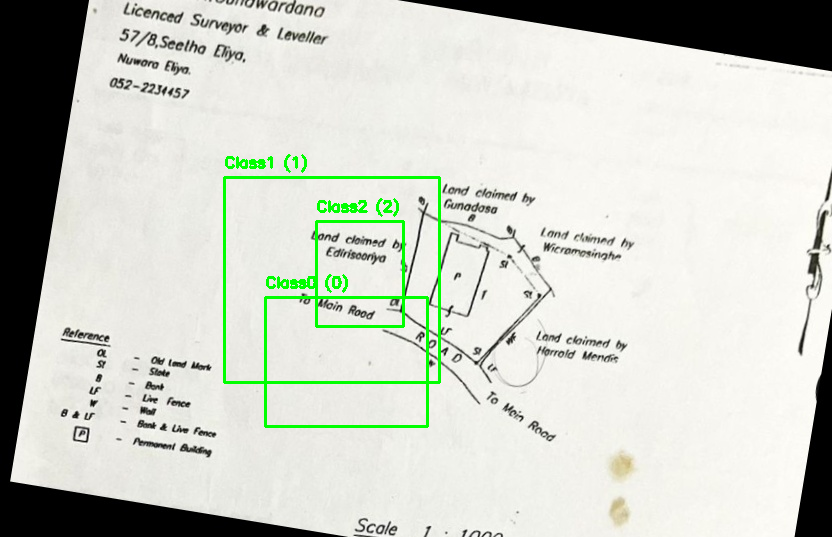

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow  # Import for displaying images in Colab

# Paths
image_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images"
label_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/yolo_labels"
class_names = ["Class0", "Class1", "Class2"]  # Update with actual class names

# Pick an image to visualize
image_name = "siteImage_aug_0.jpg"  # Change to an actual image in your dataset
image_path = os.path.join(image_dir, image_name)
label_path = os.path.join(label_dir, image_name.replace(".jpg", ".txt"))

# Load image
image = cv2.imread(image_path)
h, w, _ = image.shape  # Get image dimensions

# Read annotations
with open(label_path, "r") as f:
    lines = f.readlines()

# Debugging: Print image dimensions
print(f"Image dimensions: Width = {w}, Height = {h}")

for line in lines:
    parts = line.strip().split()
    class_id = int(parts[0])
    x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

    # Print the YOLO normalized values
    print(f"Class {class_id}: YOLO values - Center: ({x_center}, {y_center}), Width: {bbox_width}, Height: {bbox_height}")

    # Convert normalized YOLO format back to pixel coordinates
    x1 = int((x_center - bbox_width / 2) * w)
    y1 = int((y_center - bbox_height / 2) * h)
    x2 = int((x_center + bbox_width / 2) * w)
    y2 = int((y_center + bbox_height / 2) * h)

    # Print the calculated box coordinates
    print(f"Class {class_id}: Pixel coordinates - Top-left: ({x1}, {y1}), Bottom-right: ({x2}, {y2})")

    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, f'{class_names[class_id]} ({class_id})', (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show the image in Colab
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


COCO - Class: 2, BBox: [373.5983136523147, 194.99016941518835, 169.10569105691047, 157.5757575757575]
YOLO - Class: 1, BBox (normalized): [0.5506624509384254, 0.509828767603477, 0.2032520325203251, 0.2934371649455447]
Bounding box mismatch for class 2:
  COCO: [373.5983136523147, 194.99016941518835, 169.10569105691047, 157.5757575757575]
  YOLO: [0.399044, 0.52208, 0.257861, 0.381248]
COCO - Class: 1, BBox: [359.76239347493106, 298.75957074556527, 134.51589061345152, 93.00813008130075]
YOLO - Class: 0, BBox (normalized): [0.5132455994971837, 0.6429490424324315, 0.1616777531411677, 0.17319949735810194]
Bounding box mismatch for class 1:
  COCO: [359.76239347493106, 298.75957074556527, 134.51589061345152, 93.00813008130075]
  YOLO: [0.416385, 0.673732, 0.195422, 0.241247]
COCO - Class: 3, BBox: [402.8074784712356, 218.24930962155847, 63.030303030303, 86.85883222468581]
YOLO - Class: 2, BBox (normalized): [0.5220223918105614, 0.487297440845254, 0.07575757575757572, 0.16174829092120263]
Bo

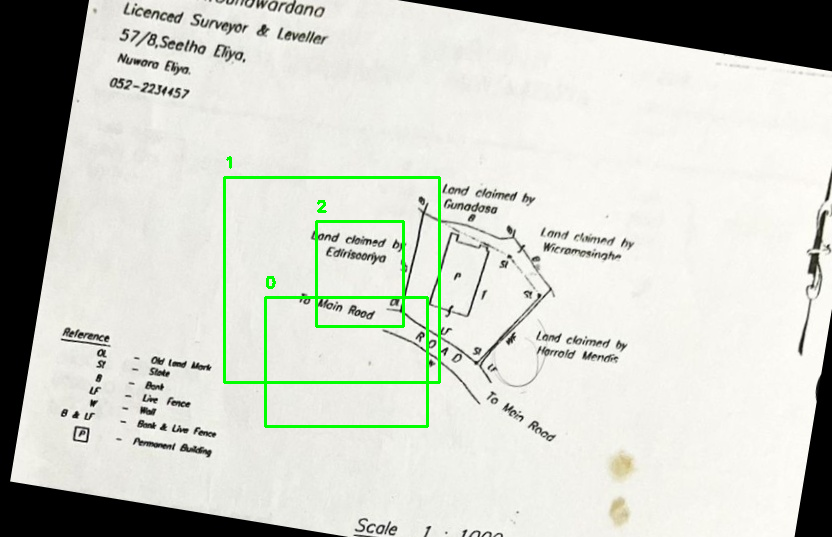

In [ ]:
# COCO -> YOLO conversion code

import json
import os
import cv2

# Paths (Update these paths as needed)
json_file_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_updated.json'  # COCO JSON file
image_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images"  # Directory of images
label_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/yolo_labels"  # Directory for YOLO labels

image_name = "siteImage_aug_0.jpg"  # The image name to compare
image_path = os.path.join(image_dir, image_name)
label_path = os.path.join(label_dir, image_name.replace(".jpg", ".txt"))

# Class mapping: Ensure this mapping is correct (adjust it as needed)
coco_to_yolo_class_mapping = {2: 1, 1: 0, 3: 2}  # Example, adjust if your class mapping differs

# Load the COCO data
with open(json_file_path, 'r') as f:
    coco_data = json.load(f)

# Get the original COCO annotations for this image
image_info = next((img for img in coco_data["images"] if img["file_name"] == image_name), None)
if image_info is None:
    print(f"Image {image_name} not found in the COCO data.")
else:
    annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == image_info["id"]]

# Load the YOLO label file
with open(label_path, 'r') as f:
    yolo_lines = f.readlines()

# Visualize the image
image = cv2.imread(image_path)
h, w, _ = image.shape  # Get image dimensions

# Print COCO annotations and compare with YOLO
for ann, yolo_line in zip(annotations, yolo_lines):
    coco_bbox = ann["bbox"]  # [x, y, width, height]
    coco_class_id = ann["category_id"]

    # Ensure class ID mapping is consistent
    yolo_class_id = coco_to_yolo_class_mapping.get(coco_class_id, coco_class_id)

    # Convert COCO bbox to YOLO format
    x, y, w_box, h_box = coco_bbox
    x_center = (x + w_box / 2) / w
    y_center = (y + h_box / 2) / h
    norm_w = w_box / w
    norm_h = h_box / h
    yolo_bbox = [x_center, y_center, norm_w, norm_h]

    # Compare the COCO and YOLO values
    print(f"COCO - Class: {coco_class_id}, BBox: {coco_bbox}")
    print(f"YOLO - Class: {yolo_class_id}, BBox (normalized): {yolo_bbox}")

    # Check if the class IDs match
    if yolo_class_id != int(yolo_line.split()[0]):
        print(f"Class ID mismatch: COCO ({coco_class_id}) vs YOLO ({yolo_class_id})")

    # Compare the bounding boxes (normalized values)
    parts = yolo_line.strip().split()
    yolo_values = list(map(float, parts[1:]))

    if not all(abs(a - b) < 1e-4 for a, b in zip(yolo_values, yolo_bbox)):
        print(f"Bounding box mismatch for class {coco_class_id}:")
        print(f"  COCO: {coco_bbox}")
        print(f"  YOLO: {yolo_values}")
    else:
        print(f"Bounding box match for class {coco_class_id}")

# Optionally: Show the image with the YOLO bounding boxes drawn
for line in yolo_lines:
    parts = line.strip().split()
    class_id = int(parts[0])
    x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

    # Convert YOLO to pixel coordinates
    x1 = int((x_center - bbox_width / 2) * w)
    y1 = int((y_center - bbox_height / 2) * h)
    x2 = int((x_center + bbox_width / 2) * w)
    y2 = int((y_center + bbox_height / 2) * h)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, f'{class_id}', (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show image in Colab (since imshow doesn't work in Colab)
from google.colab.patches import cv2_imshow
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import json
import os

# Define the correct path to your COCO annotations JSON file
json_file_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json'  # Update this with your actual file path

# Check if the file exists before attempting to open it
if not os.path.exists(json_file_path):
    print(f"File not found: {json_file_path}")
else:
    print(f"File found: {json_file_path}")

    # Load the COCO data
    with open(json_file_path, 'r') as f:
        coco_data = json.load(f)

    # Print out details from the COCO annotations for debugging
    for annotation in coco_data['annotations']:
        class_id = annotation['category_id']
        bbox = annotation['bbox']
        print(f"COCO - Class: {class_id}, BBox: {bbox}")

        # Assuming your YOLO bounding boxes are normalized and you have them in some format
        # Replace this part with your actual YOLO format bounding boxes
        yolo_class_id = class_id  # You can map this from the COCO class if necessary
        yolo_bbox = [0.399044, 0.52208, 0.257861, 0.381248]  # Placeholder YOLO values

        # Convert COCO bbox to YOLO format
        x, y, w, h = bbox  # COCO bbox format: [x, y, width, height]
        image_width = 832  # Example image width, update with actual image width
        image_height = 537  # Example image height, update with actual image height

        # Convert to YOLO format (normalized)
        x_center = (x + w / 2) / image_width
        y_center = (y + h / 2) / image_height
        bbox_width = w / image_width
        bbox_height = h / image_height

        print(f"COCO - Class: {class_id}, BBox: {bbox}")
        print(f"YOLO - Class: {yolo_class_id}, BBox (normalized): [{x_center}, {y_center}, {bbox_width}, {bbox_height}]")

    # The above steps help you ensure that the COCO data and YOLO data match up properly.
    # Further steps can involve comparing bounding boxes or visualizing them.


File found: /content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json
COCO - Class: 2, BBox: [373.5983136523147, 194.99016941518835, 169.10569105691047, 157.5757575757575]
COCO - Class: 2, BBox: [373.5983136523147, 194.99016941518835, 169.10569105691047, 157.5757575757575]
YOLO - Class: 2, BBox (normalized): [0.5506624509384254, 0.509828767603477, 0.2032520325203251, 0.2934371649455447]
COCO - Class: 1, BBox: [359.76239347493106, 298.75957074556527, 134.51589061345152, 93.00813008130075]
COCO - Class: 1, BBox: [359.76239347493106, 298.75957074556527, 134.51589061345152, 93.00813008130075]
YOLO - Class: 1, BBox (normalized): [0.5132455994971837, 0.6429490424324315, 0.1616777531411677, 0.17319949735810194]
COCO - Class: 3, BBox: [402.8074784712356, 218.24930962155847, 63.030303030303, 86.85883222468581]
COCO - Class: 3, BBox: [402.8074784712356, 218.24930962155847, 63.030303030303, 86.85883222468581]
YOLO - Class: 3, BBox (normalized): [0.5220223918105614, 0.4872

In [26]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Check if GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Assume you have 3 object classes plus background
num_classes = 1 + 3  # 1 background + 3 classes

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one (that has num_classes outputs)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the appropriate device
model.to(device)

print("Faster R-CNN model is set up and ready for training/fine-tuning!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 107MB/s]


Faster R-CNN model is set up and ready for training/fine-tuning!


In [42]:
import json
import os
import shutil

# Paths to original JSON and images directory
json_file_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json'
images_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images'

# Directories for split images
train_images_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/train_images'
val_images_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/val_images'
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/test_images'

# Create directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)

# Load the COCO JSON file
with open(json_file_path, 'r') as f:
    coco_data = json.load(f)

# Get the list of all images
all_images = coco_data["images"]

# Split into 70% train, 15% validation, and 15% test (adjust as needed)
total = len(all_images)
train_end = int(0.7 * total)
val_end = int(0.85 * total)

train_images = all_images[:train_end]
val_images = all_images[train_end:val_end]
test_images = all_images[val_end:]

# Update JSON splits for later use if needed
train_data = coco_data.copy()
train_data["images"] = train_images

val_data = coco_data.copy()
val_data["images"] = val_images

test_data = coco_data.copy()
test_data["images"] = test_images

with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_train.json', 'w') as f:
    json.dump(train_data, f)
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_val.json', 'w') as f:
    json.dump(val_data, f)
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_test.json', 'w') as f:
    json.dump(test_data, f)

print(f"Train images: {len(train_images)}, Val images: {len(val_images)}, Test images: {len(test_images)}")

# Function to filter missing images from annotations
def filter_missing_images(coco_data, images_dir):
    valid_images = []
    valid_annotations = []

    # Create a set of valid image ids
    valid_image_ids = set()
    for img_info in coco_data["images"]:
        img_path = os.path.join(images_dir, img_info["file_name"])
        if os.path.exists(img_path):
            valid_images.append(img_info)
            valid_image_ids.add(img_info["id"])

    # Filter annotations to include only those with valid image_ids
    for ann in coco_data["annotations"]:
        if ann["image_id"] in valid_image_ids:
            valid_annotations.append(ann)

    coco_data["images"] = valid_images
    coco_data["annotations"] = valid_annotations

    return coco_data

# Update coco_data by filtering out invalid image references
coco_data = filter_missing_images(coco_data, images_dir)

# Function to copy images to designated folder based on the split
def copy_images(image_list, dest_dir):
    for img_info in image_list:
        src_path = os.path.join(images_dir, img_info["file_name"])
        dest_path = os.path.join(dest_dir, img_info["file_name"])
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"Image not found: {src_path}")

copy_images(train_images, train_images_dir)
copy_images(val_images, val_images_dir)
copy_images(test_images, test_images_dir)

print("Images have been split and copied accordingly.")


Train images: 23, Val images: 5, Test images: 5
Images have been split and copied accordingly.


In [44]:
def check_annotations(dataset_name, dataset_json):
    valid_image_ids = {img["id"] for img in dataset_json["images"]}
    invalid_annotations = [ann for ann in dataset_json["annotations"] if ann["image_id"] not in valid_image_ids]

    if invalid_annotations:
        print(f"{dataset_name} has {len(invalid_annotations)} invalid annotations!")
    else:
        print(f"{dataset_name} annotations are valid.")

# Validate annotations
check_annotations("Train", train_data)
check_annotations("Val", val_data)
check_annotations("Test", test_data)


⚠️ Train has 40 invalid annotations!
⚠️ Val has 112 invalid annotations!
⚠️ Test has 112 invalid annotations!


In [5]:
def filter_missing_images_and_annotations(coco_data, images_dir):
    valid_images = []
    valid_annotations = []

    # Create a set of valid image IDs based on existing image files
    valid_image_ids = set()
    for img_info in coco_data["images"]:
        img_path = os.path.join(images_dir, img_info["file_name"])
        if os.path.exists(img_path):
            valid_images.append(img_info)
            valid_image_ids.add(img_info["id"])

    # Keep only annotations that belong to valid images
    valid_annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] in valid_image_ids]

    coco_data["images"] = valid_images
    coco_data["annotations"] = valid_annotations

    return coco_data


In [16]:
train_images_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/train_images'
val_images_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/val_images'
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/test_images'


train_data = filter_missing_images_and_annotations(train_data, train_images_dir)
val_data = filter_missing_images_and_annotations(val_data, val_images_dir)
test_data = filter_missing_images_and_annotations(test_data, test_images_dir)

# Save the fixed JSONs
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_train_fixed.json', 'w') as f:
    json.dump(train_data, f)
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_val_fixed.json', 'w') as f:
    json.dump(val_data, f)
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_test_fixed.json', 'w') as f:
    json.dump(test_data, f)

print("Fixed JSONs have been saved.")


NameError: name 'val_data' is not defined

In [47]:
# Load the fixed JSONs
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_train_fixed.json', 'r') as f:
    train_data = json.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_val_fixed.json', 'r') as f:
    val_data = json.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_test_fixed.json', 'r') as f:
    test_data = json.load(f)

# Validate again
check_annotations("Train", train_data)
check_annotations("Val", val_data)
check_annotations("Test", test_data)


✅ Train annotations are valid.
✅ Val annotations are valid.
✅ Test annotations are valid.


In [30]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import json
import os
from pycocotools.coco import COCO

class CustomCocoDataset(Dataset):
    def __init__(self, img_dir, json_file, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            json_file (string): Path to the JSON annotation file (COCO format).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = img_dir
        self.coco = COCO(json_file)
        self.ids = list(self.coco.imgToAnns.keys())  # List of image ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        # Load the image
        img = Image.open(img_path).convert("RGB")

        # Get the annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Get the bounding boxes and labels
        boxes = []
        labels = []
        for ann in anns:
            boxes.append(ann['bbox'])
            labels.append(ann['category_id'])

        # Convert to torch tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Create the target dictionary
        target = {'boxes': boxes, 'labels': labels}

        if self.transform:
            img = self.transform(img)

        return img, target


In [32]:
from torchvision import transforms

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((800, 800)),  # You can adjust the size as needed
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [33]:
from torch.utils.data import DataLoader

# Paths to the image directories and JSON files
train_img_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/train_images'
val_img_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/val_images'
test_img_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/test_images'

train_json_file = '/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_train.json'
val_json_file = '/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_val.json'
test_json_file = '/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels_test.json'

# Create datasets
train_dataset = CustomCocoDataset(train_img_dir, train_json_file, transform)
val_dataset = CustomCocoDataset(val_img_dir, val_json_file, transform)
test_dataset = CustomCocoDataset(test_img_dir, test_json_file, transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Train data size: {len(train_loader.dataset)}")
print(f"Validation data size: {len(val_loader.dataset)}")
print(f"Test data size: {len(test_loader.dataset)}")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train data size: 33
Validation data size: 33
Test data size: 33
